In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.metric.metric import Metric
from financial_common.risk.risk_type import RiskType
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
import numpy as np

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
ori = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("cryptocurrencies")
market.disconnect()

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("crypto",{"ticker":"BTC-USD"})
benchmark = p.utc_date(benchmark)
benchmark["close"] = benchmark["close"].astype(float)
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"close")

In [7]:
rolling_window = 14

In [12]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("crypto", {"ticker": ticker})
        price.rename(columns={"close":"adjclose"},inplace=True)
        for col in price.columns:
            if col not in ["date", "ticker"]:
                try:
                    price[col] = price[col].astype(float)
                    
                except Exception as e:
                    print(str(e))
                    continue
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
        
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            price["dividend"] = 0
            for member in Metric:
                price = member.calculate(price,timeframe=rolling_window)
            for member in Indicator:
                price = member.calculate(price,timeframe=rolling_window)
            for member in RiskType:
                price = member.apply(price,timeframe=rolling_window)
            prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 23.13it/s]


In [13]:
model_end = 2023
backtest_end = 2026
simulation = pd.concat(prices)
## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)
simulation.columns

Index(['start', 'low', 'high', 'open', 'adjclose', 'volume', 'ticker', 'date',
       'year', 'month', 'quarter', 'week', 'day', 'dividend',
       'reference_price', 'reference_volume', 'reference_high',
       'reference_low', 'average_return', 'standard_dev',
       'rolling_dollar_volume', 'simple_moving_average', 'drawdown',
       'distance', 'next_close', 'price_to_return', 'optimal', 'adr', 'sma',
       'sma_corr', 'ema', 'ema_corr', 'ema_volume_corr', 'bollinger_upper',
       'bollinger_lower', 'momentum', 'roc', 'williams_r', 'obv', 'vwap',
       'market_impact', 'atr', 'coefficient_of_variation'],
      dtype='object')

In [26]:
portfolios = PortfolioSelection.generate_possible_portfolios(ranking_metrics=[member.label for member in Indicator],group_percentages=[1],num_of_groups=[1],max_prices=[10],min_prices=[0.1],stoplosses=[0.05],rolling_windows=[rolling_window])
portfolios = [x for x in portfolios if x.timeframe.value == "day" and x.selection_type.label != "long_short" and x.position_type.label == "long" and x.ranking_metric != "optimal" and x.grouping_type.value == "distance"]
len(portfolios)

150

In [27]:
analysises = []
for portfolio in tqdm(portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.50it/s]


In [28]:
a = pd.DataFrame(analysises)
a.columns

Index(['ranking_metric', 'timeframe', 'position_type', 'grouping_type',
       'selection_type', 'allocation_type', 'risk_type',
       'selection_percentage', 'stoploss', 'num_of_groups', 'max_price',
       'min_price', 'rolling_window', 'date', 'pnl', 'raw_pnl', 'downside',
       'coefficient_of_variation', 'portfolio_std', 'sharpe_ratio',
       'tracking_error', 'information_ratio', 'portfolio'],
      dtype='object')

In [29]:
a.drop(["date","risk_type","timeframe","allocation_type","selection_percentage"],axis=1).sort_values("pnl",ascending=False).head(20)

,ranking_metric,position_type,grouping_type,selection_type,stoploss,num_of_groups,max_price,min_price,rolling_window,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,sharpe_ratio,tracking_error,information_ratio,portfolio
44,ema_corr,long,DISTANCE,bottom,0.05,1,10,0.1,14,2.989884,3.097725,0.95,3.520069,0.849382,1.681935,0.638397,2.237802,<financial_common.portfolio_management.portfol...
45,ema_corr,long,DISTANCE,bottom,0.05,1,10,0.1,14,2.909597,3.014542,0.95,3.520383,0.826500,1.631360,0.615819,2.189473,<financial_common.portfolio_management.portfol...
48,ema_corr,long,DISTANCE,bottom_blacklist,0.05,1,10,0.1,14,2.589450,2.702849,0.95,3.318215,0.780375,1.317537,0.577767,1.779561,<financial_common.portfolio_management.portfol...
49,ema_corr,long,DISTANCE,bottom_blacklist,0.05,1,10,0.1,14,2.519916,2.630270,0.95,3.318535,0.759346,1.262452,0.557160,1.720579,<financial_common.portfolio_management.portfol...
41,ema_corr,long,DISTANCE,mixed,0.05,1,10,0.1,14,1.958148,2.139063,0.95,5.384738,0.363648,1.091359,0.185981,2.133927,<financial_common.portfolio_management.portfol...
40,ema_corr,long,DISTANCE,mixed,0.05,1,10,0.1,14,1.797257,1.962909,0.95,6.396382,0.280980,0.839843,0.124376,1.897307,<financial_common.portfolio_management.portfol...
106,williams_r,long,DISTANCE,top_blacklist,0.05,1,10,0.1,14,1.657011,1.887843,0.95,7.739081,0.214110,0.447121,0.132603,0.721952,<financial_common.portfolio_management.portfol...
107,williams_r,long,DISTANCE,top_blacklist,0.05,1,10,0.1,14,1.646804,1.876215,0.95,7.740035,0.212764,0.401976,0.132491,0.645522,<financial_common.portfolio_management.portfol...
148,atr,long,DISTANCE,bottom_blacklist,0.05,1,10,0.1,14,1.567861,1.694993,0.95,4.116985,0.380827,0.017285,0.188333,0.034951,<financial_common.portfolio_management.portfol...
136,market_impact,long,DISTANCE,top_blacklist,0.05,1,10,0.1,14,1.520521,1.592624,0.95,7.588961,0.200360,-0.203418,0.124490,-0.327389,<financial_common.portfolio_management.portfol...


In [30]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

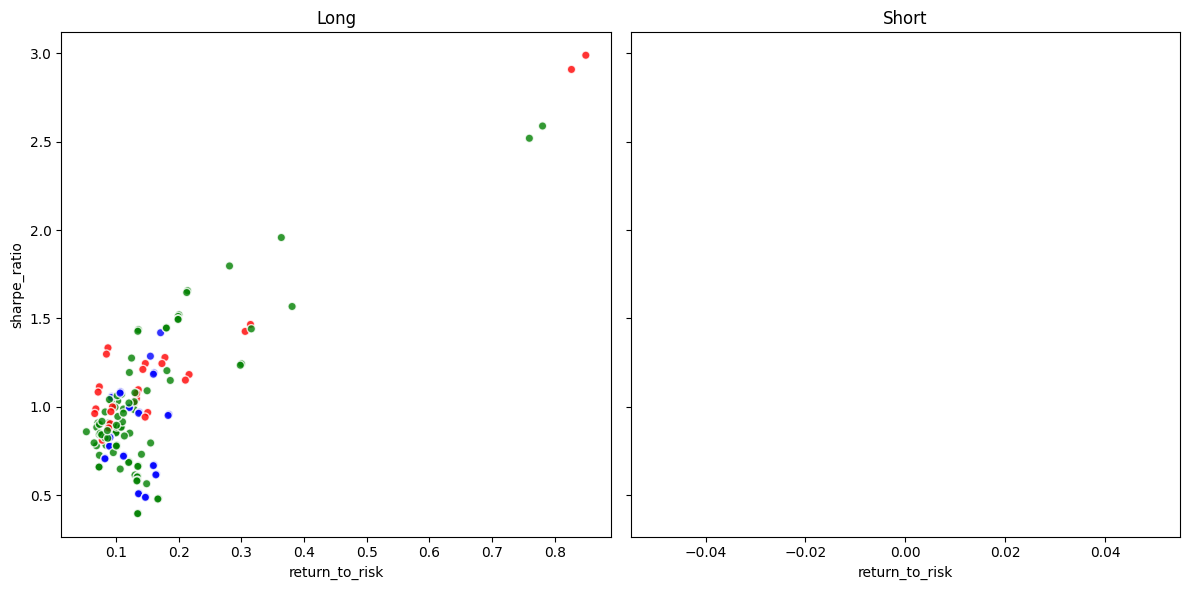

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [32]:
top = a[(a["timeframe"]=="DAY") & (a["ranking_metric"]!="optimal")].sort_values("pnl",ascending=False).to_dict("records")[0]
top

{'ranking_metric': 'ema_corr',
 'timeframe': 'DAY',
 'position_type': 'long',
 'grouping_type': 'DISTANCE',
 'selection_type': 'bottom',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 1,
 'stoploss': 0.05,
 'num_of_groups': 1,
 'max_price': 10,
 'min_price': 0.1,
 'rolling_window': 14,
 'date': Timestamp('2025-05-19 00:00:00+0000', tz='UTC'),
 'pnl': 2.9898835186548434,
 'raw_pnl': 3.0977245792592303,
 'downside': 0.95,
 'coefficient_of_variation': 3.5200686776497503,
 'portfolio_std': 0.8493821548536102,
 'sharpe_ratio': 1.6819348932962614,
 'tracking_error': 0.6383966167798262,
 'information_ratio': 2.2378024044011515,
 'portfolio': <financial_common.portfolio_management.portfolio.Portfolio at 0x1a39e0d8ad0>,
 'color': 'red',
 'return_to_risk': 3.5200686776497503}

In [33]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

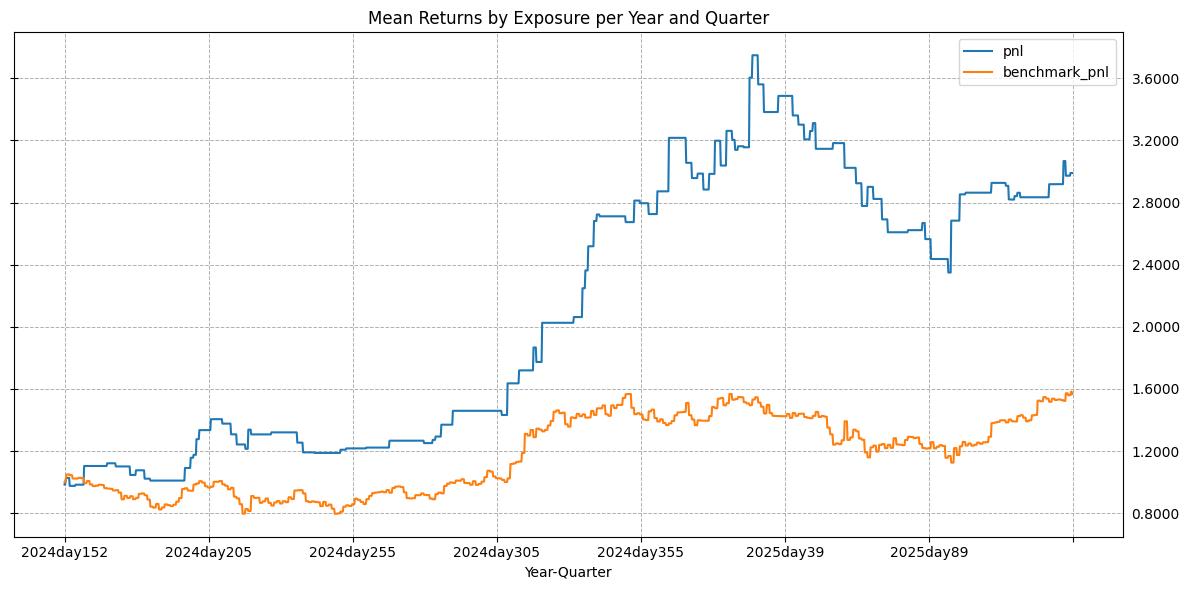

In [34]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + pm.timeframe.value + portfolio[pm.timeframe.value].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [35]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
XRP-USD,0.020390
HNT-USD,0.012744
UNI-USD,0.008680
PENDLE-USD,0.008070
ARB-USD,0.005445
MATIC-USD,0.004490
DOGE-USD,0.002737
ICP-USD,0.002213
XLM-USD,0.000926


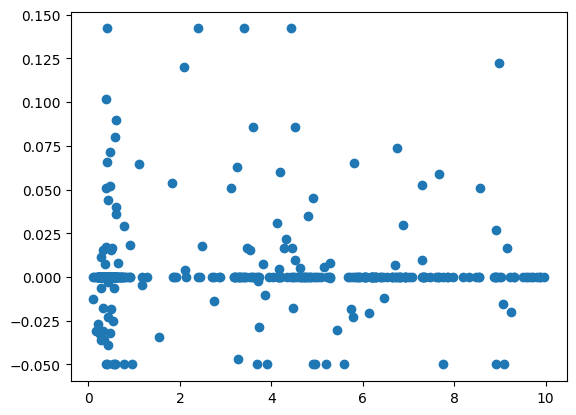

In [36]:
plt.scatter(trades["adjclose"],trades["return"])
plt.show()

In [37]:
ori.cloud_connect()
ori.drop("crypto_results")
ori.store("crypto_results",pd.DataFrame([top]).drop("portfolio",axis=1))
ori.disconnect()